# Модель, предсказывающая температуру расплавленного состояния сплава стали

<b>ОПИСАНИЕ ПРОЕКТА</b>

Чтобы <b>оптимизировать</b> производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

Пути оптимизации:<br>
- использование этой модели как части конвейера моделей(результат этой модели будет входными данными для другой)<br>
- перегрев стали есть перерасход,модель поможет в организации мероприятий от излишнего нагрева<br>
- менее сильные колебания обуспечат более длительный срок службы облицовки ковша<br>

<b>Цель:</b> разработать прототип модели машинного обучения c достаточным качеством (MAE <6.8) для предсказания температуры расплавленного состояния сплава стали

<b>Описание этапа обработки стали:</b>

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн, облицованном изнутри огнеупорным кирпичом, в крышке установлены графитовые электроды и датчики для измерения химического состава сплава

1)Расплавленную сталь заливают в ковш

2)Измеряют температуру стали и производят её химический анализ

3)Потом температуру на несколько минут повышают с помощью электродов, добавляют легирующие материалы(сыпучие и проволочные добавки) ,продувают сплав инертным газом(перемешивают) и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

4)Тогда расплавленная сталь разливается в заготовки - слябы.

<b>ОПИСАНИЕ ДАННЫХ</b>

Данные состоят из файлов, полученных из разных источников:
* data_arc.csv — данные об электродах;
* data_bulk.csv — данные о подаче сыпучих материалов (объём);
* data_bulk_time.csv — данные о подаче сыпучих материалов (время);
* data_gas.csv — данные о продувке сплава газом;
* data_temp.csv — результаты измерения температуры;
* data_wire.csv — данные о проволочных материалах (объём);
* data_wire_time.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

Целевой признак находится в таблице `data_temp.csv` - температура розива в слябы. То есть должно быть как минимум 2 замера температуры в партии - начальная(с которой сплав попадает в ковш) и конечная(температура розлива в слябы) ,несоответствующие партии включены в анализ не будут.

<b>ПЛАН ПРОЕКТА</b>

- Проведение обзора данных (EDA)

 - Подготовка и анализ данных
   - Подключение необходимых библиотек;
   - Самописные функции;
   - Чтение таблиц из файлов в переменные ,получение общей информации о таблицах, выявление особенностей в данных.
   - Выводы
 - Предобработка данных
   - Обработка выявленных особенностей в данных.
   - Выводы
 - Исследование итоговой таблицы с данными
   - Соединение таблиц;
   - Анализ итоговой таблицы;
   - Отбор 10 - ти самых важных признаков;
   - Переименование столбцов.
   - Выводы

- Построение модели машинного обучения
 - Обучение моделей
   - Разделение данных на выборки;
   - Обучение модели случайного леса с перебором гиперпараметров;
   - Масштабирование данных;
   - Обучение модели линейной регрессии с перебором гиперпараметров;
   - Обучение модели градиентного бустинга с перебором гиперпараметров;
   - Константная модель.
   - Выбор лучшей модели

 - Тестирование лучшей модели на тестовой выборке.
   
- Общий вывод

## Проведение обзора данных (EDA)

### Подготовка и анализ данных

#### Подключение необходимых библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from scipy.stats import uniform
from sklearn.dummy import DummyRegressor

#### Самописные функции

In [2]:
#Функция для получения общей информации о таблице
def data_hi(data):
    display(data.head(5))
    display(data.info())
    display(data.describe())
    print(f'Количество строк-дубликатов: ',data.duplicated().sum())
    return data

#### Чтение таблиц из файлов в переменные ,получение общей информации о таблицах, выявление особенностей в данных(неверный тип данных, аномалии, пропуски, дубликаты), выделение признаков и таргета

##### Электроды

In [3]:
try:
    data_arc = pd.read_csv('yapracticum/data_arc.csv')
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [4]:
data_arc = data_hi(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Количество строк-дубликатов:  0


<AxesSubplot:xlabel='Активная мощность'>

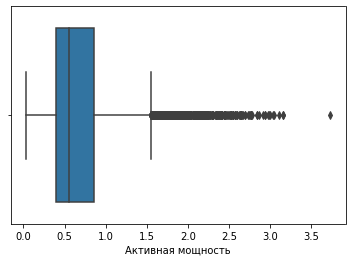

In [5]:
sns.boxplot(data_arc['Активная мощность'])

<AxesSubplot:xlabel='Реактивная мощность'>

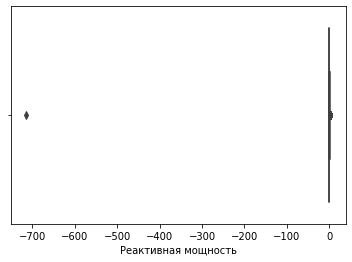

In [6]:
sns.boxplot(data_arc['Реактивная мощность'])

В таблице с данными об электродах есть следущие особенности:
- тип данных в столбцах `Начало нагрева дугой` и `Конец нагрева дугой` необходимо изменить на `datetime`
- супервыбросы в столбцах `Активная мощность`(>3.5) и `Реактивная мощность`(<0) необходимо удалить,остальные выбросы оставить как есть

Необходимо создать новые признаки , которые и войдут в сводную таблицу:<br>
- `Время нагрева дугой` из признаков `Начало нагрева дугой` и `Конец нагрева дугой`
- `Полная мощность` из признаков `Активная мощность` и `Реактивная мощность`

### Сыпучие материалы : объём и время

In [7]:
try:
    data_bulk = pd.read_csv('/Users/dasha/Desktop/final_steel/data_bulk.csv')
except:
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')

In [8]:
data_bulk = data_hi(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Количество строк-дубликатов:  0


Посмотрим все ли строки с уникальным значением номера партии:

In [9]:
data_bulk['key'].nunique()

3129

В таблице с данными об объёме сыпучих материалов есть следущие особенности:
- тип данных во всех столбцах `Bulk` необходимо изменить на `int`
- выбросы в части столбцов оставим как есть
- многочисленые пропуски во всех столбцах заменим на `0`,что будет обозначать, что сыпучий материал не добавлялся в ковш

Все столбцы `Bulk` войдут в сводную таблицу,редкие `Bulk` объединим в один признак

In [10]:
try:
    data_bulk_time = pd.read_csv('/Users/dasha/Desktop/final_steel/data_bulk_time.csv')
except:
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')

In [11]:
data_bulk_time = data_hi(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Количество строк-дубликатов:  0


Данные этой таблицы не понадобятся для обучения моделей.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
Да, время как фактор - точно в модель не вставляем. У нас НЕ ВРЕМЕННЫЕ ряды.

### Продувка сплава газом(объём на партию)

In [12]:
try:
    data_gas = pd.read_csv('/Users/dasha/Desktop/final_steel/data_gas.csv')
except:
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [13]:
data_gas = data_hi(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Количество строк-дубликатов:  0


In [14]:
data_gas['key'].nunique()

3239

<AxesSubplot:xlabel='Газ 1'>

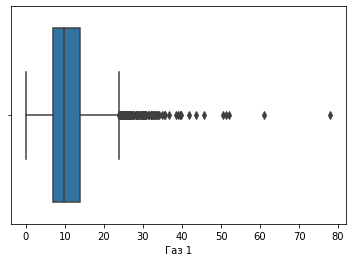

In [15]:
sns.boxplot(data_gas['Газ 1'])

В таблице с данными о продувке сплава газом есть следущие особенности:
- Выбросы (>24) оставим как есть

Признак `Газ 1` войдет в сводную таблицу

### Результаты измерения температуры

In [16]:
try:
    data_temp = pd.read_csv('/Users/dasha/Desktop/final_steel/data_temp.csv')
except:
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [17]:
data_temp = data_hi(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Количество строк-дубликатов:  0


<AxesSubplot:xlabel='Температура'>

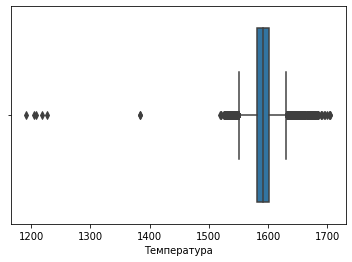

In [18]:
sns.boxplot(data_temp['Температура'])

В таблице с данными о результатах измерения температуры есть следущие особенности:
- типы данных в столбце `Время замера`  необходимо изменить на `datetime`,в столбце `Температура` - на `int`
- выбросы - и левый,  и правый хвост.Строки со значениями температуры ниже 1400(температура плавления стали) - супервыбросы,необходимо удалить,так как сталь попадает в ковш уже в расплавленном состоянии и такие значения невозможны.
- все партии с пропусками необходимо удалить,так как температура-целевой признак для обучения моделей

Таблица содержит целевой признак - `температура розлива в слябы` и признак - `температура поступления стали в ковш`,их необходимо выделить в отдельные

### Проволочные материалы : объём и время

In [19]:
try:
    data_wire = pd.read_csv('/Users/dasha/Desktop/final_steel/data_wire.csv')
except:
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [20]:
data_wire = data_hi(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Количество строк-дубликатов:  0


В таблице с данными об объёме проволочных материалов есть следущие особенности:
- тип данных во всех столбцах `Wire` необходимо изменить на `int`
- есть выбросы в части столбцов ,оставим их как есть
- многочисленые пропуски во всех столбцах заменим на `0`,что будет обозначать, что сыпучий материал не добавлялся в ковш

Все столбцы `Wire` войдут в сводную таблицу,редкие `Wire` объединим в один признак


In [21]:
try:
    data_wire_time = pd.read_csv('/Users/dasha/Desktop/final_steel/data_wire_time.csv')
except:
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [22]:
data_wire_time = data_hi(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Количество строк-дубликатов:  0


Данные этой таблицы не понадобятся для обучения моделей.

#### Выводы

Данные семи таблиц загружены .В пяти таблицах выявлены особенности, которые будут обработаны на следующем этапе.Две таблицы не понадобятся для обученя моделей. 

## Предобработка данных

### Обработка выявленных особенностей в данных

#### Электроды

In [23]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

In [24]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
data_arc = data_arc[data_arc['Активная мощность']  < 3.5]

In [25]:
data_arc['Время нагрева дугой'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

In [26]:
full_power = np.sqrt(np.power(np.array(data_arc['Активная мощность']), 2) + np.power(np.array(data_arc['Реактивная мощность']), 2))
data_arc['full_power'] = full_power

In [27]:
data_arc['arc_time'] = data_arc['Время нагрева дугой'].dt.seconds

Создадим окончательный вариант таблицы `Электроды` с двумя признаками: `full_power` и `arc_time`

In [28]:
data_arc = pd.pivot_table(data_arc,
                             values = ['full_power','arc_time'],
                             index = 'key',
                             aggfunc = np.sum)

data_arc

,arc_time,full_power
key,,
1,1098,5.826395
2,811,3.649216
3,655,2.989534
4,741,3.814962
5,869,4.035758
...,...,...
3237,909,4.844982
3238,546,2.696542
3239,1216,5.611883


#### Сыпучие материалы

In [29]:
data_bulk = data_bulk.fillna(0)

In [30]:
data_bulk = data_bulk.astype('int64')

Редкие присадки(<1% от 3129) объединим в столбец `rare_bulk`

In [31]:
data_bulk['rare_bulk'] = data_bulk['Bulk 2'] + data_bulk['Bulk 7'] + data_bulk['Bulk 8'] + data_bulk['Bulk 9'] + data_bulk['Bulk 13']
data_bulk.drop(['Bulk 2','Bulk 7', 'Bulk 8','Bulk 9','Bulk 13'], axis= 1 , inplace= True )

Создадим окончательный вариант таблицы `Сыпучие материалы` с 11-тью признаками:

In [32]:
data_bulk.set_index('key',inplace = True)
data_bulk

,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,rare_bulk
key,,,,,,,,,,,
1,0,0,43,0,0,0,0,206,150,154,0
2,0,0,73,0,0,0,0,206,149,154,0
3,0,0,34,0,0,0,0,205,152,153,0
4,0,0,81,0,0,0,0,207,153,154,0
5,0,0,78,0,0,0,0,203,151,152,0
...,...,...,...,...,...,...,...,...,...,...,...
3237,0,170,0,0,0,0,0,252,130,206,0
3238,0,126,0,0,0,0,0,254,108,106,0
3239,0,0,0,0,114,0,0,158,270,88,0


#### Продувка сплава газом(объём на партию)

Окончательный вариант таблицы `Газ` содержит 1 признак

In [33]:
data_gas.set_index('key',inplace = True)

In [34]:
data_gas

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
...,...
3237,5.543905
3238,6.745669
3239,16.023518


#### Результаты измерения температуры

In [35]:
data_temp.dropna(inplace = True)

In [36]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp['Температура'] = data_temp['Температура'].astype('int64')

In [37]:
data_temp = data_temp[data_temp['Температура'] > 1400]

In [38]:
data_temp.sort_values(by=['key', 'Время замера'])

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571
1,1,2019-05-03 11:25:53,1604
2,1,2019-05-03 11:29:11,1618
3,1,2019-05-03 11:30:01,1601
4,1,2019-05-03 11:30:39,1613
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569
15883,3238,2019-08-31 23:30:31,1584
15886,3239,2019-09-01 01:31:47,1598
15894,3240,2019-09-01 02:39:01,1617


In [39]:
data_temp.drop(['Время замера'], axis= 1 , inplace= True )

Оставим только те партии, в которых есть как минимум 2 замера температуры

In [40]:
counts = data_temp['key'].value_counts()
data_temp = data_temp[data_temp['key'].isin(counts [counts>=2].index)]

Оставим только первый и последний замеры температуры по каждой партии

In [41]:
data_temp = data_temp.groupby('key').apply(lambda x:x.iloc[[0,-1]])

In [42]:
ft_dict = {} 
st_dict = {} 

for index, row in data_temp.iterrows():
    if row['key'] not in ft_dict: 
        ft_dict[row['key']] = row['Температура']
    else:
        st_dict[row['key']] = row['Температура']
        

data_temp = pd.DataFrame({'key': list(ft_dict.keys()), 'first_temperature': list(ft_dict.values()), 'second_temperature': list(st_dict.values())})

Окончательный вариант таблицы `Температура ` содержит 1 признак и таргет(`last_temperature`)

In [43]:
data_temp.set_index('key',inplace = True)
data_temp

,first_temperature,second_temperature
key,,
1,1571,1613
2,1581,1602
3,1596,1599
4,1601,1625
5,1576,1602
...,...,...
2495,1570,1591
2496,1554,1591
2497,1571,1589


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 3</b></u></p>
    <p>ПРИНЯТО! Это важная часть проекта!</p>
</div

#### Проволочные материалы

In [44]:
data_wire = data_wire.fillna(0)

In [45]:
data_wire = data_wire.astype('int64')

Редкие присадки(<1% от 3081) объединим в столбец rare_wire

In [46]:
data_wire['rare_wire'] = data_wire['Wire 4'] + data_wire['Wire 5'] + data_wire['Wire 7'] + data_wire['Wire 8'] + data_wire['Wire 9']
data_wire.drop(['Wire 4','Wire 5', 'Wire 7','Wire 8','Wire 9'], axis= 1 , inplace= True )

Создадим окончательный вариант таблицы `Проволочные материалы` с 5-тью признаками:

In [47]:
data_wire.set_index('key',inplace = True)
data_wire

,Wire 1,Wire 2,Wire 3,Wire 6,rare_wire
key,,,,,
1,60,0,0,0,0
2,96,0,0,0,0
3,91,0,0,0,0
4,89,0,0,0,0
5,89,9,0,0,0
...,...,...,...,...,...
3237,38,0,0,0,0
3238,56,0,0,0,0
3239,143,0,0,0,0


### Выводы

Аномалии,пропуски,дубликаты и несоответствия в типах данных обработали .Сгенерированы новые признаки.

## Исследование итоговой таблицы с данными

### Соединение таблиц

Объеденим все таблицы по номеру партии

In [48]:
df = pd.merge(data_arc, data_bulk, on='key', how='inner')
df = pd.merge(df, data_gas, on='key', how='inner')
df = pd.merge(df, data_temp, on='key', how='inner')
df = pd.merge(df, data_wire, on='key', how='inner')

### Анализ итоговой таблицы

In [49]:
df = data_hi(df)

,arc_time,full_power,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,...,Bulk 15,rare_bulk,Газ 1,first_temperature,second_temperature,Wire 1,Wire 2,Wire 3,Wire 6,rare_wire
key,,,,,,,,,,,,,,,,,,,,,
1,1098,5.826395,0,0,43,0,0,0,0,206,...,154,0,29.749986,1571,1613,60,0,0,0,0
2,811,3.649216,0,0,73,0,0,0,0,206,...,154,0,12.555561,1581,1602,96,0,0,0,0
3,655,2.989534,0,0,34,0,0,0,0,205,...,153,0,28.554793,1596,1599,91,0,0,0,0
4,741,3.814962,0,0,81,0,0,0,0,207,...,154,0,18.841219,1601,1625,89,0,0,0,0
5,869,4.035758,0,0,78,0,0,0,0,203,...,152,0,5.413692,1576,1602,89,9,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   arc_time            2329 non-null   int64  
 1   full_power          2329 non-null   float64
 2   Bulk 1              2329 non-null   int64  
 3   Bulk 3              2329 non-null   int64  
 4   Bulk 4              2329 non-null   int64  
 5   Bulk 5              2329 non-null   int64  
 6   Bulk 6              2329 non-null   int64  
 7   Bulk 10             2329 non-null   int64  
 8   Bulk 11             2329 non-null   int64  
 9   Bulk 12             2329 non-null   int64  
 10  Bulk 14             2329 non-null   int64  
 11  Bulk 15             2329 non-null   int64  
 12  rare_bulk           2329 non-null   int64  
 13  Газ 1               2329 non-null   float64
 14  first_temperature   2329 non-null   int64  
 15  second_temperature  2329 non-null   int64  
 16  Wire 1

None

,arc_time,full_power,Bulk 1,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 10,Bulk 11,Bulk 12,...,Bulk 15,rare_bulk,Газ 1,first_temperature,second_temperature,Wire 1,Wire 2,Wire 3,Wire 6,rare_wire
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000
mean,807.211249,3.939705,3.427651,47.348218,37.303564,2.640189,22.430228,5.052812,4.245170,208.415629,...,119.952769,4.960498,11.375600,1587.386003,1593.365393,102.224989,17.536711,3.230571,0.975526,0.936883
std,337.534282,1.762445,12.412132,75.310430,58.643238,22.402293,55.790873,20.917800,22.515487,157.062272,...,84.640443,48.347994,6.392041,23.619841,11.200915,43.502716,33.528909,27.916013,8.671298,7.358217
min,57.000000,0.257637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008399,1519.000000,1541.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,581.000000,2.735080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,...,0.000000,0.000000,7.282948,1571.000000,1587.000000,73.000000,0.000000,0.000000,0.000000,0.000000
50%,778.000000,3.773603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,...,107.000000,0.000000,10.100950,1587.000000,1593.000000,101.000000,0.000000,0.000000,0.000000,0.000000
75%,993.000000,4.892791,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,282.000000,...,204.000000,0.000000,14.216688,1603.000000,1598.000000,128.000000,23.000000,0.000000,0.000000,0.000000
max,3282.000000,16.972619,185.000000,454.000000,281.000000,603.000000,503.000000,159.000000,313.000000,1849.000000,...,405.000000,1014.000000,77.995040,1660.000000,1653.000000,330.000000,282.000000,385.000000,180.000000,118.000000


Количество строк-дубликатов:  0


В итоговую таблицу вошли 2329 объектов моделирования - ковшей,20 признаков и 1 таргет.

<AxesSubplot:>

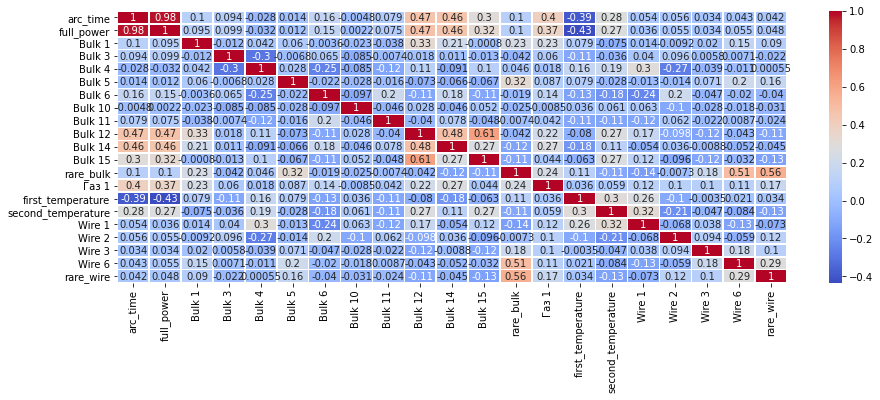

In [50]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)

Обнаружена мультиколлинеарность между признаками `full_power  ` и ` arc_time `,оставим только один из них - ` full_power `

In [51]:
df.drop('arc_time', axis= 1 , inplace= True )

### Отбор 10-ти самых важных признаков

In [52]:
selector = ExtraTreesRegressor()
result = selector.fit(df.drop('second_temperature', axis=1), df['second_temperature'])
importances = pd.DataFrame(result.feature_importances_, index=df.drop('second_temperature', axis=1).columns, columns=['importance'])
importances = importances.sort_values(by='importance', ascending=False).head(10)
importances

,importance
first_temperature,0.181436
full_power,0.176671
Wire 1,0.093985
Bulk 15,0.073565
Bulk 12,0.060147
Bulk 6,0.057671
Bulk 14,0.055940
Газ 1,0.054465
Wire 2,0.053039
Bulk 4,0.037790


In [53]:
features = df.loc[:,df.columns.isin(importances.index)]
features

,full_power,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Газ 1,first_temperature,Wire 1,Wire 2
key,,,,,,,,,,
1,5.826395,43,0,206,150,154,29.749986,1571,60,0
2,3.649216,73,0,206,149,154,12.555561,1581,96,0
3,2.989534,34,0,205,152,153,28.554793,1596,91,0
4,3.814962,81,0,207,153,154,18.841219,1601,89,0
5,4.035758,78,0,203,151,152,5.413692,1576,89,9
...,...,...,...,...,...,...,...,...,...,...
2495,3.986869,0,0,256,129,223,7.125735,1570,89,0
2496,5.057033,63,0,256,129,226,9.412616,1554,114,0
2497,2.885017,85,0,230,124,226,6.271699,1571,94,9


### Переименование столбцов

In [54]:
features.columns = ['full_power','bulk_4','bulk_6','bulk_12','bulk_14','bulk_15','gas','first_temperature','wire_1','wire_2']

### Выводы

Сформирована итоговая таблица из 10 самых важных признаков,устранена мультиколлинеарность,переименованы столбцы.

## Построение модели машинного обучения

### Обучение моделей

#### Разделение данных на выборки

In [55]:
target = df['second_temperature']

In [56]:
state = np.random.RandomState(100423)

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=state)

f"Размер обучающей выборки: {x_train.shape}",\
f"Размер тестовой  выборки: {x_test.shape}"

('Размер обучающей выборки: (1746, 10)', 'Размер тестовой  выборки: (583, 10)')

Создадим список, в который будем добавлять обученные модели

In [57]:
Models = []

#### Обучение модели случайного леса

In [58]:
rf = RandomForestRegressor()

param_dist = {
    'n_estimators': [100, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_dist, n_iter = 50, cv = 5, random_state=state, scoring='neg_mean_absolute_error', n_jobs = -1)
rf_random.fit(x_train, y_train)
best_params = rf_random.best_params_
best_params

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': None}

In [59]:
mae_rf = rf_random.best_score_
mae_rf

-6.33386343421421

In [60]:
Models.append(['Случайный лес', mae_rf])

#### Масштабирование данных

In [61]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### Обучение модели линейной регрессии 

In [62]:
lr = LinearRegression()

param_distributions = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}

lr_random = RandomizedSearchCV(lr, param_distributions, cv=5, n_iter=10, scoring='neg_mean_absolute_error', random_state=state)
lr_random.fit(x_train, y_train)
best_params = lr_random.best_params_
best_params

{'fit_intercept': True, 'copy_X': True}

In [63]:
mae_lr = lr_random.best_score_
mae_lr

-6.397828381383424

In [64]:
Models.append(['Линейная регрессия',mae_lr])

#### Обучение модели CatBoost

In [65]:
cb = CatBoostRegressor(verbose = False,loss_function='MAE',
                          random_state=100423)

params = {'learning_rate': uniform(loc=0.01, scale=0.3),
          'depth': [4, 5, 6],
          'iterations': [100, 500],
          'l2_leaf_reg': uniform(loc=1, scale=10)}

cb_random = RandomizedSearchCV(estimator=cb,
                            param_distributions=params,
                            n_iter=50,
                            scoring='neg_mean_absolute_error',
                            cv=5,
                            random_state=100423)

cb_random.fit(x_train, y_train)

best_params = cb_random.best_params_
best_params

{'depth': 4,
 'iterations': 500,
 'l2_leaf_reg': 9.75563194220592,
 'learning_rate': 0.08331291244569322}

In [66]:
mae_cb = cb_random.best_score_
mae_cb

-5.955139819625333

In [67]:
cb = CatBoostRegressor(verbose =False,loss_function='MAE',
                               random_state=100423,
                               **best_params)

In [68]:
cb.fit(x_train, y_train)

In [69]:
Models.append(['CatBoost', mae_cb])

#### Константная модель

In [70]:
dummy = DummyRegressor(strategy = 'mean')
dummy.fit(x_train,y_train)
y_pred = dummy.predict(x_test)
mae_d = mean_absolute_error(y_test,y_pred)
mae_d

8.130447639200806

In [71]:
Models.append(['Константная модель', mae_d])

#### Выбор лучшей модели

Оформим результаты по обучению моделей в таблицу

In [72]:
result = pd.DataFrame(Models, columns=['model', 'rmse'])
result

,model,rmse
0,Случайный лес,-6.333863
1,Линейная регрессия,-6.397828
2,CatBoost,-5.955140
3,Константная модель,8.130448


MAE всех моделей соответствует требованиям.<br>
Наименьшей MAE удалось добиться на CatBoost модели со следующими гиперпараметрами:'depth': 6,'iterations': 500,'l2_leaf_reg': 10.902497338187823,'learning_rate': 0.02022618280060956.

### Тестирование лучшей модели на тестовой выборке

In [73]:
predictions = cb.predict(x_test)
mae = mean_absolute_error(y_test,predictions)
mae

6.0544801704479685

Значение метрики MAE на тестовой выборке меньше 6.8.Рекомендуем заказчику модель CatBoost.

### Анализ важности факторов

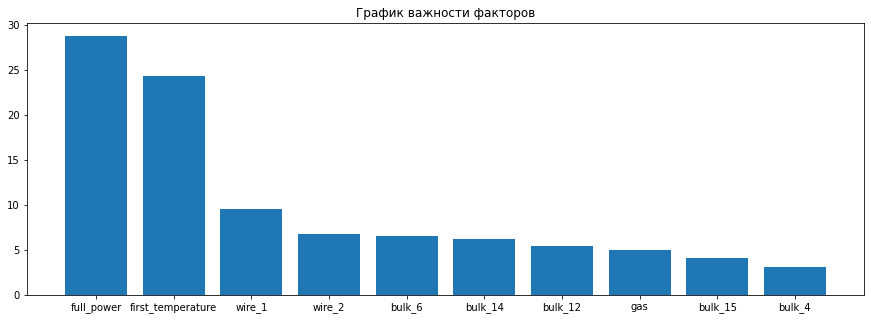

In [74]:
importances = cb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(15, 5))
plt.title("График важности факторов")
plt.bar(range(x_test.shape[1]), importances[indices])
plt.xticks(range(x_test.shape[1]), [features.columns[i] for i in indices])
plt.show()

Посмотрим как поменяется метрика , если оставить только 3 фактора

In [75]:
features = features[['full_power','first_temperature','wire_1']]

state = np.random.RandomState(100423)

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=state)

f"Размер обучающей выборки: {x_train.shape}",\
f"Размер тестовой  выборки: {x_test.shape}"

('Размер обучающей выборки: (1746, 3)', 'Размер тестовой  выборки: (583, 3)')

In [76]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [77]:
cb = CatBoostRegressor(verbose = False,loss_function='MAE',
                          random_state=100423)

params = {'learning_rate': uniform(loc=0.01, scale=0.3),
          'depth': [4, 5, 6],
          'iterations': [100, 500],
          'l2_leaf_reg': uniform(loc=1, scale=10)}

cb_random = RandomizedSearchCV(estimator=cb,
                            param_distributions=params,
                            n_iter=50,
                            scoring='neg_mean_absolute_error',
                            cv=5,
                            random_state=100423)

cb_random.fit(x_train, y_train)
best_params = cb_random.best_params_
cb_random.best_score_

-6.461634720704919

In [78]:
cb = CatBoostRegressor(verbose =False,loss_function='MAE',
                               random_state=100423,
                               **best_params)
cb.fit(x_train, y_train)

In [79]:
predictions = cb.predict(x_test)
mae = mean_absolute_error(y_test,predictions)
mae

6.627160557992644

Качество моделей,обученных на 10-ти и 3-ёх признаках отличается незначительно(MAE на тестовой выборке соответсвенно 6.0544801704479685 и 6.627160557992644).Целевое значение (<6.8) достигается и при обучении на 3 признаках.

## Общий вывод

- Были выполнены все пункты плана работы над проектом
- Все модели были обучены с автоматизированным подбором гиперпараметров
- Сложность была с определением целевого признака и выделением признака и целевого признака из одного столбца таблицы
- В решении данной задачи можно выделить следующие ключевые шаги:
 - Загрузка всех таблиц
 - Предобработка данных
 - Объединение таблиц в общую итоговую таблицу
 - Разбивка на выборки
 - Обучение моделей
 - Выбор лучшей модели
 - Проверка лучшей модели на тестовой выборке
 - Анализ важности факторов
-  Наименьшей MAE (6.05 на тестовой выборке) удалось добиться на CatBoost модели со следующими гиперпараметрами:'random_state':100423,'depth': 6,'iterations': 500,'l2_leaf_reg': 10.902497338187823,'learning_rate': 0.02022618280060956.
- Модель была обучена на следующих признаках:
 - full_power(признак создан из двух других признаков с применением формулы )
 - bulk_4 
 - bulk_6 
 - bulk_12
 - bulk_14 
 - bulk_15
 - gas 
 - first_temperature(признак выделен как первый известный замер по партии)
 - wire_1
 - wire_2
- Для улучшения модели можно:
 - оптимизировать 3 самых важных фактора : полную мощность ,температуру сплава и объемы проволочной добавки №1.
   - фиксировать случаи перегрева сплава и параметры  , которые наблюдались в этот момент
   - мощность электродов и объемы проволочной добавки можно рассчитать точнее , тогда нужной температуры и нужного состава сплава можно будет добиваться быстрее
   - подавать сплав для ввода добавок уже с более высокой температурой
 - собрать дополнительную информацию по производству (составу сплава , составу газа  , работе электродов) и ввести эти данные как признаки для обучения моделей
 
 